# Chapter 7 Problem 7 (Gelman & Hill)

*Repeat the previous exercise using a Poisson regression example.*

In [13]:
library("arm")
library("foreign")
library("ggplot2")

For the purposes of this exercise we will use an artificial dataset by UCLA. The goal is to predict the number of awards earned by students at one high school. Predictors of the number of awards earned include the type of program in which the student was enrolled (e.g., vocational, general or academic) and the score on their final exam in math.

In [2]:
award <- read.csv("http://www.ats.ucla.edu/stat/data/poisson_sim.csv")
award <- within(award, {
  c.math <- (math - mean(math, na.rm=TRUE)) / (2 * sd(math, na.rm=TRUE))
  prog <- factor(prog, levels=1:3, labels=c("general", "academic", "vocational"))
  id <- factor(id)
})
summary(award)

       id        num_awards           prog          math      
 1      :  1   Min.   :0.00   general   : 45   Min.   :33.00  
 2      :  1   1st Qu.:0.00   academic  :105   1st Qu.:45.00  
 3      :  1   Median :0.00   vocational: 50   Median :52.00  
 4      :  1   Mean   :0.63                    Mean   :52.65  
 5      :  1   3rd Qu.:1.00                    3rd Qu.:59.00  
 6      :  1   Max.   :6.00                    Max.   :75.00  
 (Other):194                                                  
     c.math        
 Min.   :-1.04847  
 1st Qu.:-0.40802  
 Median :-0.03442  
 Mean   : 0.00000  
 3rd Qu.: 0.33917  
 Max.   : 1.19310  
                   

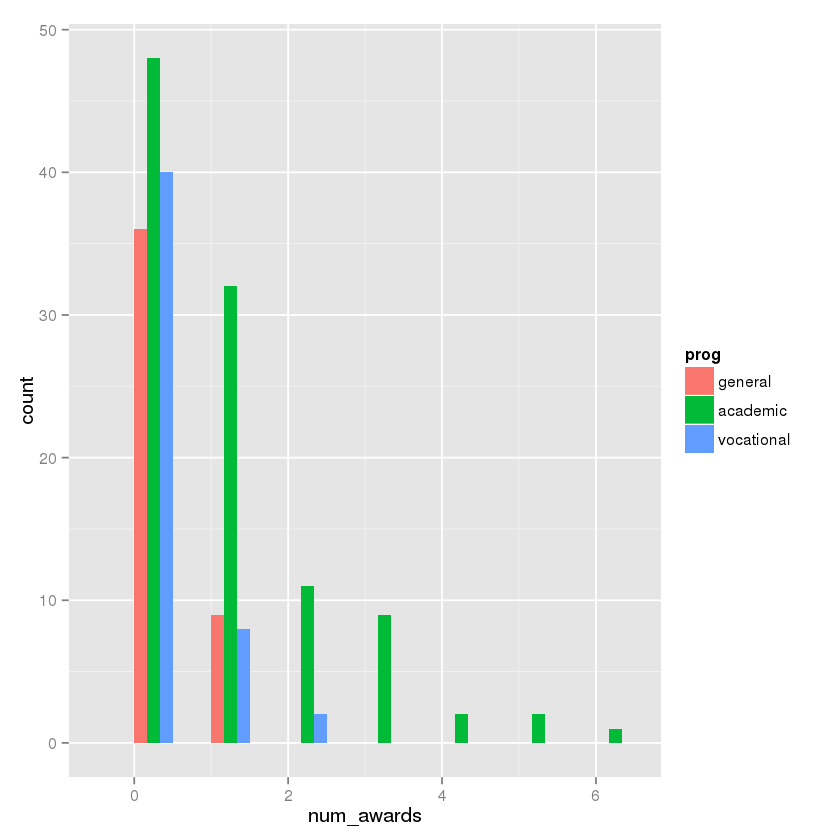

In [3]:
ggplot(award, aes(num_awards, fill = prog)) +
  geom_histogram(binwidth=.5, position="dodge")

In [4]:
str(award$prog)

 Factor w/ 3 levels "general","academic",..: 3 1 3 3 3 1 3 3 3 3 ...


glm(formula = num_awards ~ prog + math, family = "poisson", data = award)
               coef.est coef.se
(Intercept)    -5.25     0.66  
progacademic    1.08     0.36  
progvocational  0.37     0.44  
math            0.07     0.01  
---
  n = 200, k = 4
  residual deviance = 189.4, null deviance = 287.7 (difference = 98.2)


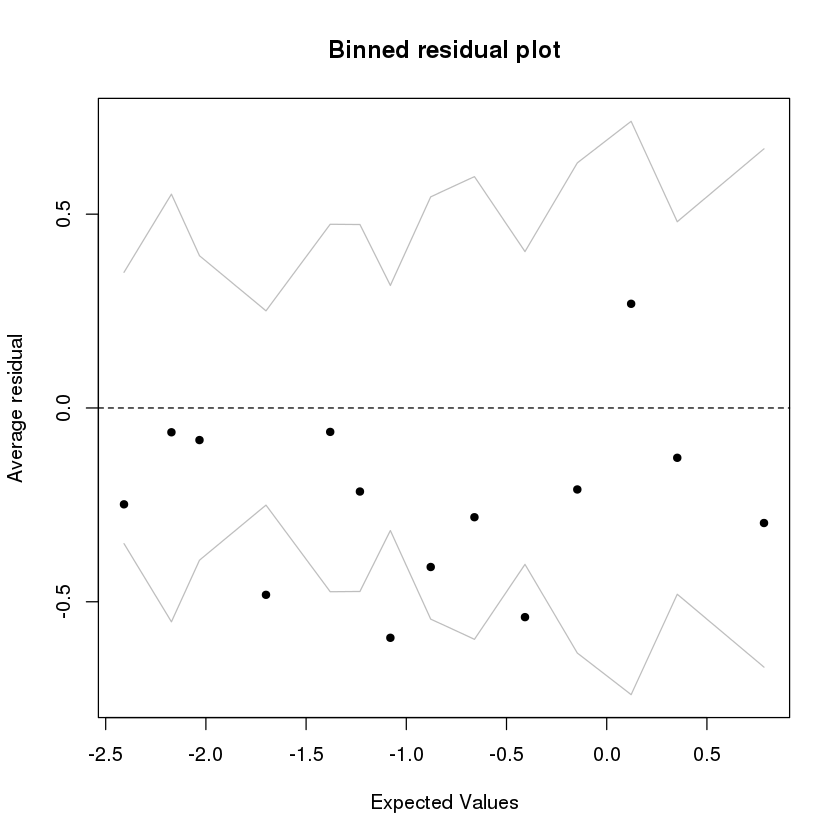

In [5]:
m1 <- glm(num_awards ~ prog + math, family="poisson", data=award)
display(m1)
binnedplot(predict(m1), residuals(m1))

To get the uncertainty for the simulated estimates..

In [6]:
t(apply(coef(sim), 2, quantile, c(.025, .975)))

ERROR: Error in t(apply(coef(sim), 2, quantile, c(0.025, 0.975))): error in evaluating the argument 'x' in selecting a method for function 't': Error: object of type 'closure' is not subsettable



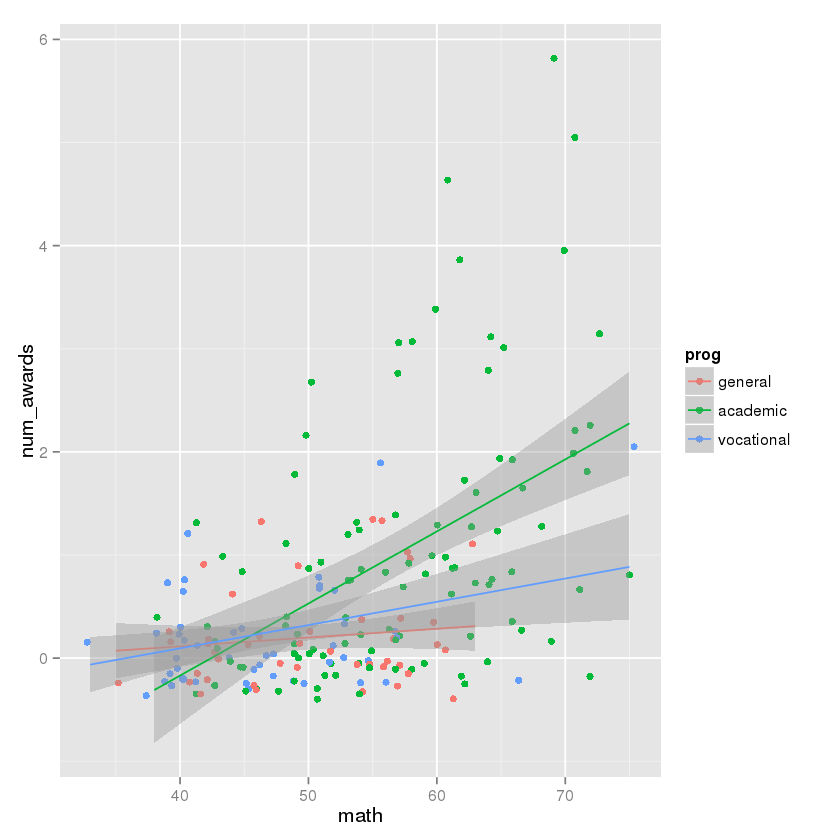

In [7]:
ggplot(data=award, aes(x=math, y=num_awards, col=prog)) + 
    geom_point(position="jitter") +
    geom_smooth(method="glm")

We will now generate the predictive distribution for observations with a particular combination of levels of all the predictors in the regression.

In [10]:
# create a dummy variable to flag when the number of awards is greater than zero
award$award.pos <- ifelse(award$num_awards>0, 1, 0)

# fit model 1 (logistic regression: zero or more awards?) and model 2 (poisson regression: if more than zero, 
#   how many?)
fit.1a <- glm(award.pos ~ prog + math, family=binomial(link="logit"), data=award)
fit.1b <- glm(num_awards ~ prog + math, family="poisson", data=award, subset=num_awards>0)

# create two hypothetical pupils
x.new2 <- c(1, 1, 0, 59) # constant term=1, prog:academic=1, prog:vocational=0, math=59
x.new3 <- c(1, 1, 0, 70) # constant term=1, prog:academic=1, prog:vocational=0, math=70
n.sims <- 1000

# simulate 1,000 new betas and sigmas
sim.1a <- sim(fit.1a, n.sims)
sim.1b <- sim(fit.1b, n.sims)

# use the new betas and sigmas to generate two predictive distributions of num. awards for the hypothetical pupils
award.sim1 <- rep(NA, n.sims)
prob.award.pos <- invlogit(coef(sim.1a) %*% x.new2)
award.pos.sim <- rbinom(n.sims, 1, prob.award.pos)
award.sim1 <- ifelse(award.pos.sim==0, 0, exp(rnorm (n.sims, coef(sim.1b) %*% x.new2, sigma.hat(sim.1b))))

award.sim2 <- rep(NA, n.sims)
prob.award.pos <- invlogit(coef(sim.1a) %*% x.new3)
award.pos.sim <- rbinom(n.sims, 1, prob.award.pos)
award.sim2 <- ifelse(award.pos.sim==0, 0, exp(rnorm(n.sims, coef(sim.1b) %*% x.new3, sigma.hat(sim.1b))))

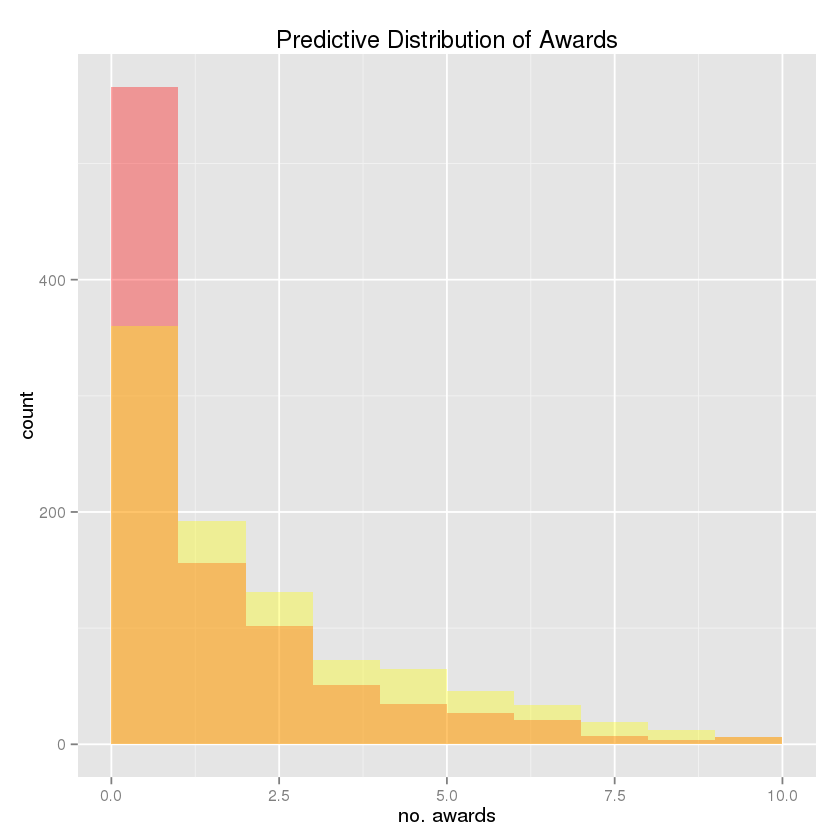

In [12]:
ggplot(data=data.frame(x1=award.sim1, x2=award.sim2)) + 
    geom_histogram(aes(x=x1), binwidth=1, fill="red", alpha=.35) +
    geom_histogram(aes(x=x2), binwidth=1, fill="yellow", alpha=.35) +
    xlim(c(0,10)) + labs(title="Predictive Distribution of Awards", x="no. awards")

We must notice the choice of using a Poisson regression was after all not ideal. We should have chosen a censored regression model in order to limit the number of awards to a maximum of 6.

From the results of the simulation we can see how, given the same academic track choice, a higher score in the math test results in highers chances to have 1 or more awards.